# Week 10: Colab Experiment

# I. Introduction
In this exercise, we apply CNN to MNIST data to classify the hand written digits.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

# Data Loading
Load the data from the MNIST dataset

In [2]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# Visualize dataset sample
Show some sample.

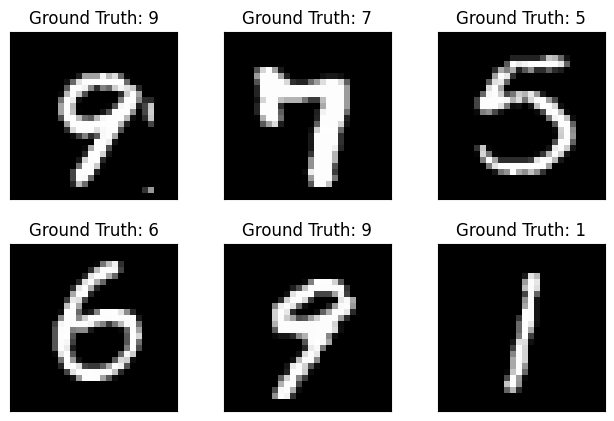

In [3]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# II. Methods


In [4]:
from os import X_OK

# This class implements a minimal network (which still does okay)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Valid convolution, 1 channel in, 2 channels out, stride 1, kernel size = 3
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3)
        # Dropout for convolutions
        self.drop = nn.Dropout2d()
        # Fully connected layer
        self.fc1 = nn.Linear(338, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.drop(x)
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.log_softmax(x)
        return x

In [5]:
# TODO: Change above Net to Net2 class to implement

# 1. A valid convolution with kernel size 5, 1 input channel and 10 output channels
# 2. A max pooling operation over a 2x2 area
# 3. A Relu
# 4. A valid convolution with kernel size 5, 10 input channels and 20 output channels
# 5. A 2D Dropout layer
# 6. A max pooling operation over a 2x2 area
# 7. A relu
# 8. A flattening operation
# 9. A fully connected layer mapping from (whatever dimensions we are at-- find out using .shape) to 50
# 10. A ReLU
# 11. A fully connected layer mapping from 50 to 10 dimensions
# 12. A softmax function.

class Net2(nn.Module):
    def __init__(self):

        super(Net2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d()
        )
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [6]:
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(1216)

In [7]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [8]:
# Main training routine
# TODO: Read it and understand what it does, you would need to implement it in the next colab HW

def train(epoch, model, optimizer):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:

      pred = output.data.max(1, keepdim=True)[1]
      correct = pred.eq(target.data.view_as(pred)).sum()
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [9]:
# Run on test data
# TODO: Read it and understand what it does, you would need to implement it in the next colab HW

def test(model):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return 100. * correct / len(test_loader.dataset)

In [10]:
# Train and test Model 1

# Create network
model = Net()
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Get initial performance
test(model)
# Train for ten epochs
n_epochs = 10
for epoch in range(1, n_epochs + 1):
  train(epoch, model, optimizer)
accuracy1 = test(model)


C:\Users\codeamon\AppData\Local\Temp\ipykernel_106904\1795650187.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
c:\Users\codeamon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.5911, Accuracy: 1002/10000 (10%)

Train Epoch: 1 [0/60000]	Loss: 2.762738
Train Epoch: 1 [640/60000]	Loss: 2.432890
Train Epoch: 1 [1280/60000]	Loss: 2.275907
Train Epoch: 1 [1920/60000]	Loss: 2.243393
Train Epoch: 1 [2560/60000]	Loss: 2.205828
Train Epoch: 1 [3200/60000]	Loss: 2.098188
Train Epoch: 1 [3840/60000]	Loss: 2.121952
Train Epoch: 1 [4480/60000]	Loss: 1.931935
Train Epoch: 1 [5120/60000]	Loss: 1.940472
Train Epoch: 1 [5760/60000]	Loss: 2.020670
Train Epoch: 1 [6400/60000]	Loss: 1.814095
Train Epoch: 1 [7040/60000]	Loss: 1.604658
Train Epoch: 1 [7680/60000]	Loss: 1.602771
Train Epoch: 1 [8320/60000]	Loss: 1.577708
Train Epoch: 1 [8960/60000]	Loss: 1.465954
Train Epoch: 1 [9600/60000]	Loss: 1.235356
Train Epoch: 1 [10240/60000]	Loss: 1.072694
Train Epoch: 1 [10880/60000]	Loss: 1.366254
Train Epoch: 1 [11520/60000]	Loss: 1.169053
Train Epoch: 1 [12160/60000]	Loss: 1.393694
Train Epoch: 1 [12800/60000]	Loss: 1.171778
Train Epoch: 1 [13440/60000]	Loss: 1.4

In [11]:
# Train and test Model 2

# Create network
model2 = Net2()
# Initialize model weights
model2.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.5)

# Get initial performance
test(model2)
# Train for ten epochs
n_epochs = 10
for epoch in range(1, n_epochs + 1):
  train(epoch, model2, optimizer)
accuracy2 = test(model2)


Test set: Avg. loss: 2.4005, Accuracy: 1326/10000 (13%)

Train Epoch: 1 [0/60000]	Loss: 2.507610
Train Epoch: 1 [640/60000]	Loss: 2.102225
Train Epoch: 1 [1280/60000]	Loss: 1.794129
Train Epoch: 1 [1920/60000]	Loss: 1.852212
Train Epoch: 1 [2560/60000]	Loss: 1.475319
Train Epoch: 1 [3200/60000]	Loss: 1.494001
Train Epoch: 1 [3840/60000]	Loss: 1.450663
Train Epoch: 1 [4480/60000]	Loss: 0.828227
Train Epoch: 1 [5120/60000]	Loss: 1.322323
Train Epoch: 1 [5760/60000]	Loss: 0.979544
Train Epoch: 1 [6400/60000]	Loss: 1.067897
Train Epoch: 1 [7040/60000]	Loss: 0.952976
Train Epoch: 1 [7680/60000]	Loss: 0.789140
Train Epoch: 1 [8320/60000]	Loss: 0.684815
Train Epoch: 1 [8960/60000]	Loss: 1.076699
Train Epoch: 1 [9600/60000]	Loss: 0.745523
Train Epoch: 1 [10240/60000]	Loss: 0.714706
Train Epoch: 1 [10880/60000]	Loss: 0.986711
Train Epoch: 1 [11520/60000]	Loss: 0.793512
Train Epoch: 1 [12160/60000]	Loss: 0.684430
Train Epoch: 1 [12800/60000]	Loss: 0.699340
Train Epoch: 1 [13440/60000]	Loss: 0.6

## III. Results

Here we train the CNN model and apply it to the test set. There are 10 epochs in training. There is no validation set here, we simply take the model at the end of the training procedure.

In [12]:
print(f"Model 1 Accuracy: {round(float(accuracy1.numpy()),2)}%")
print(f"Model 2 Accuracy: {round(float(accuracy2.numpy()),2)}%")

Model 1 Accuracy: 92.54%
Model 2 Accuracy: 98.72%


C:\Users\codeamon\AppData\Local\Temp\ipykernel_106904\1795650187.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


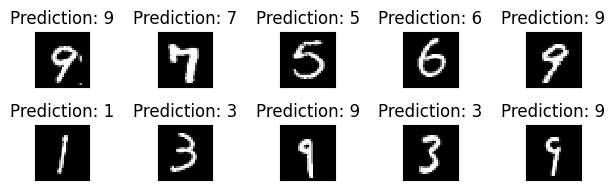

In [13]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()

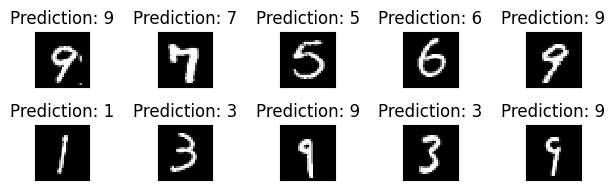

In [14]:
# Run network on data we got before and show predictions
output = model2(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()

# IV. Conclusion and Discussion

In this study, the object aim to classify handwritten digits from widly-used MNIST dataset by implementing custom convlutional neural networks (CNNs) in PyTorch.

1. **Import Libraries**

   Import essential libraries such as PyTorch, Torchvision, Matplotlib, and others required for building and training the models.

2. **Load and Preprocess MNIST Dataset**
   
   The MNIST dataset is loaded from Torchvision libaray. The dataset consists of grayscale images of handwritten digits from 0 to 9, with corresponding labels. Data loaders are created for training and testing sets, facilitating batch processing for efficient model training. Apply neccessary transformations, such as converting images to tensors and normalizing pixel values based on the dataset's mean and standard deviation, are applied to ensure consistent input for the neural network.

3. **Visualize Dataset Sample**
   
   To gain insight into the dataset, sample images from the first batch of the test set are displayed, along with their ground truth labels. This visualization helps us understand the diversity and the structure of the data.

4. **Define Neural Network Architectures**:

   Two neural networks, Net and Net2, are constructed for classifying MNIST digits. Each network has a different level of complexity, with Net2 incorporating a more sophisticated architecture, rendering it more capable of capturing intricate patterns within the MNIST dataset compared to Net. Two neural network architectures are defined as below.

   - **Model 1 (`Net`)**: A simple CNN with one convolutional layer, a dropout layer, and a fully connected layer.
   
      ```bash=
      ----------------------------------------------------------------
            Layer (type)               Output Shape         Param #
      ================================================================
                  Conv2d-1            [-1, 2, 26, 26]              20
               Dropout2d-2            [-1, 2, 26, 26]               0
               MaxPool2d-3            [-1, 2, 13, 13]               0
                    ReLU-4            [-1, 2, 13, 13]               0
                  Linear-5                   [-1, 10]           3,390
              LogSoftmax-6                   [-1, 10]               0
      ================================================================
      Total params: 3,410
      Trainable params: 3,410
      Non-trainable params: 0
      ----------------------------------------------------------------
      ```

   - **Model 2 (`Net2`)**: A more complex CNN with two convolutional layers, dropout, pooling layers, and two fully connected layers.

      ```bash=
      ----------------------------------------------------------------
            Layer (type)               Output Shape         Param #
      ================================================================
                  Conv2d-1           [-1, 10, 24, 24]             260
                    ReLU-2           [-1, 10, 24, 24]               0
               MaxPool2d-3           [-1, 10, 12, 12]               0
                  Conv2d-4             [-1, 20, 8, 8]           5,020
                    ReLU-5             [-1, 20, 8, 8]               0
               MaxPool2d-6             [-1, 20, 4, 4]               0
               Dropout2d-7             [-1, 20, 4, 4]               0
                  Linear-8                   [-1, 50]          16,050
                    ReLU-9                   [-1, 50]               0
                 Linear-10                   [-1, 10]             510
             LogSoftmax-11                   [-1, 10]               0
      ================================================================
      Total params: 21,840
      Trainable params: 21,840
      Non-trainable params: 0
      ----------------------------------------------------------------
      ```

5. **Set Random Seed**

   Fix the seed for reproducibility of results across runs.

6. **Initialize Models and Set Hyperparameters**

   Instantiate the models, apply weight initialization based on Kaiming He initialization, and set SGD with momentum as the optimizer to accelerate training and achieve faster convergence. Effective weight initialization can improve model convergence during the training, while the optimizer, using SGD with momentum, updates model parameters by minimizing the loss through computed gradients to accelerate training.

7. **Train and Evaluate the Models**
   
   For each epoch

   - Loop over the training data in batches.
   - Perform forward pass to compute predictions.
   - Compute the loss using negative log-likelihood.
   - Backpropagate the loss and update the model weights using the optimizer.
   - Print training progress and loss at intervals.

   After training, evaluate each model on the test dataset

   - Calculate the average loss and accuracy.
   - Print out the performance metrics.

8. **Display Results**

   - Print the final accuracy of both models.
   - Visualize predictions by the models on sample test images.

9. **Conclusion and Discussion**

   The test results reveal that Net2 outperforms Net in both accuracy and average loss, suggesting it is a more effective model for classifying MNIST handwritten digits task.

   - Accuracy comparison: Net achieves an accuracy of 92.54%, and Net2 has an accuracy of 98.72%. This difference in accuracy (over 6%) is significant and implies that Net2 generalizes better to unseen data.
   - Loss comparison: Net has an average loss of 0.2689, while Net2 has a much lower average loss of 0.0388. This significant reduction in loss for Net2 indicates not only greater prediction accuracy but also a higher confidence in its predictions.

   In conclusion, Net2 provides a more accurate and reliable performance compared to Net, making it the preferable choice for deployment in applications requiring high accuracy. The difference in loss and accuracy between the two models suggest that Net2 has a more optimal architecture, better tuning, and other improvements that enhance its predictive power on this dataset.